## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import qstools.indicators as qsi
import math

import warnings
warnings.simplefilter('ignore')

In [2]:
cids_dmca = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # DM currency areas
cids_dmec = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']  # DM euro area countries
cids_latm = ['ARS', 'BRL', 'COP', 'CLP', 'MXN', 'PEN']  # Latam countries
cids_emea = ['HUF', 'ILS', 'PLN', 'RON', 'RUB', 'TRY', 'ZAR']  # EMEA countries
cids_emas = ['CNY', 'HKD', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'SGD', 'THB', 'TWD']  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

In [4]:
from_DB = True
path_to_feather = "..//..//data//feathers//" 

xcats = ['CPIH_SA_P1M1ML12', 'CPIC_SA_P1M1ML12', 'CPIH_SA_P1M1ML12_D1M1ML3', 'CPIC_SA_P1M1ML12_D1M1ML3',
        'CPIH_SJA_P3M3ML3AR', 'CPIC_SJA_P3M3ML3AR', 'CPIH_SJA_P6M6ML6AR', 'CPIC_SJA_P6M6ML6AR' ]

if from_DB:
    dbi = qsi.DownloadQuantamentalIndicators(username="rsueppel",
                                             host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                             password="l3oT7^WerjY#O!9EGqvL",
                                             database="qs_jpm_point_time")
    dfd = dbi.get_xcat(cross_section = cids, xcat = xcats).reset_index(drop=True)
    dfd.to_feather(f'{path_to_feather}dfd_cpitrends_qmtl.ftr')   
else:
    dfd = pd.read_feather(f'{path_to_feather}dfd_cpitrends_qmtl.ftr')

In [5]:
dfd[['cross_section', 'xcat']] = dfd['ticker'].str.split('_', 1, expand=True)  # split string column
dfd['real_date'] = pd.to_datetime(dfd['real_date'])

In [6]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301280 entries, 0 to 1301279
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   ticker         1301280 non-null  object        
 1   real_date      1301280 non-null  datetime64[ns]
 2   value          1301280 non-null  float64       
 3   grading        1301280 non-null  object        
 4   eop_lag        1301280 non-null  int64         
 5   mop_lag        1301280 non-null  int64         
 6   cross_section  1301280 non-null  object        
 7   xcat           1301280 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 79.4+ MB


In [7]:
cids_exp = sorted(list(set(cids) - set(cids_dmec + ['ARS', 'HKD'])))  # expected cids
xcats_exp = xcats  # expected xcats, in most cases equal to xcats

print('Missing xcats across df: ', set(xcats_exp) - set(dfd['xcat'].unique()))  # any xcats missing
xcats_used = sorted(list(set(xcats_exp).intersection(set(dfd['xcat'].unique()))))
for xcat in xcats_used:
    cids_xcat = dfd.loc[dfd['xcat']==xcat, 'cross_section'].unique()
    print(f'Missing cids for {xcat}: ', set(cids_exp) - set(cids_xcat))  # any cross section missing?

Missing xcats across df:  set()
Missing cids for CPIC_SA_P1M1ML12:  set()
Missing cids for CPIC_SA_P1M1ML12_D1M1ML3:  set()
Missing cids for CPIC_SJA_P3M3ML3AR:  set()
Missing cids for CPIC_SJA_P6M6ML6AR:  set()
Missing cids for CPIH_SA_P1M1ML12:  set()
Missing cids for CPIH_SA_P1M1ML12_D1M1ML3:  set()
Missing cids for CPIH_SJA_P3M3ML3AR:  set()
Missing cids for CPIH_SJA_P6M6ML6AR:  set()


## Functions

In [8]:
def check_availability(df, xcats, cids=None, size=None):
    """Display starting years across extended categories and cross sections"""
    
    dfx = df[df['xcat'].isin(xcats)]
        
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    df_rstarts = dfx[['cross_section', 'xcat', 'real_date']].groupby(['cross_section', 'xcat']).min()
    df_rstarts['real_date']=pd.DatetimeIndex(df_rstarts.loc[:,'real_date']).year
    df_rstarts = df_rstarts.unstack().loc[:,'real_date']
    
    if size is None:
        size = (max(len(cids)/2, 15), max(1, len(xcats)/2))
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(df_rstarts.T, cmap='Reds', center=2002, annot=True, fmt='.0f', linewidth=1, cbar=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

In [9]:
def bars_sds(df, xcats, start_year=2000, cids=None, val=None, title=None, ylab=None):
    """Plot level bars and SD ranges across extended categories and cross sections"""
    
    filt1 = df['real_date'].dt.year >= start_year
    filt2 = df['xcat'].isin(xcats)
    
    dfx = dfd[filt1 & filt2]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    sns.set(style="whitegrid")
    
    if val is None:
        val = 'value'
    if title is None:
        title = f'Means and standard deviations since {start_year}'
    if ylab is None:
        ylab=""

    g = sns.catplot(
        data=dfx, kind="bar", height=6, aspect=2.5,
        x="cross_section", y=val, hue="xcat",
        ci="sd", palette="Paired", alpha=.6, order = cids
    )
    g.despine(left=True)
    g.axes[0][0].axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=1)
    g.fig.suptitle(title, y = 1.03, fontsize=14)
    g.set_axis_labels("", ylab)
    plt.show()

In [10]:
def timeline_grid(df, xcats, start_year=2000, cids=None, val='value', hue=None, ncol=3, same_y=False):
    """Plot grid of timelines of one or more extended categories across sections"""
    
    filt1 = df['real_date'].dt.year >= start_year
    filt2 = df['xcat'].isin(xcats)
    
    dfx = dfd[filt1 & filt2]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]    

    sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
    fg = sns.FacetGrid(dfx, col='cross_section', col_wrap = ncol, sharey=same_y, aspect = 1.7, col_order = cids)
    fg.map_dataframe(sns.lineplot, x='real_date', y=val, hue=hue, ci=None)
    fg.map(plt.axhline, y=0, c=".5")
    fg.set_titles(col_template='{col_name}')
    fg.add_legend()
    plt.show()

## Availability

Missing cross sections:  set()


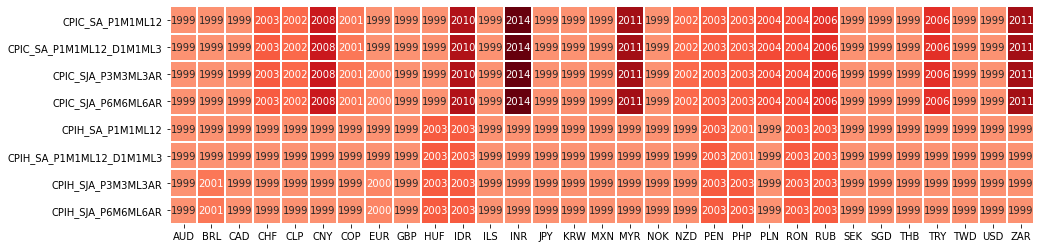

In [11]:
check_availability(dfd, xcats, cids=cids_exp)

## Distributions and timelines

### Annual headline and core inflation rates

Missing cross sections:  set()


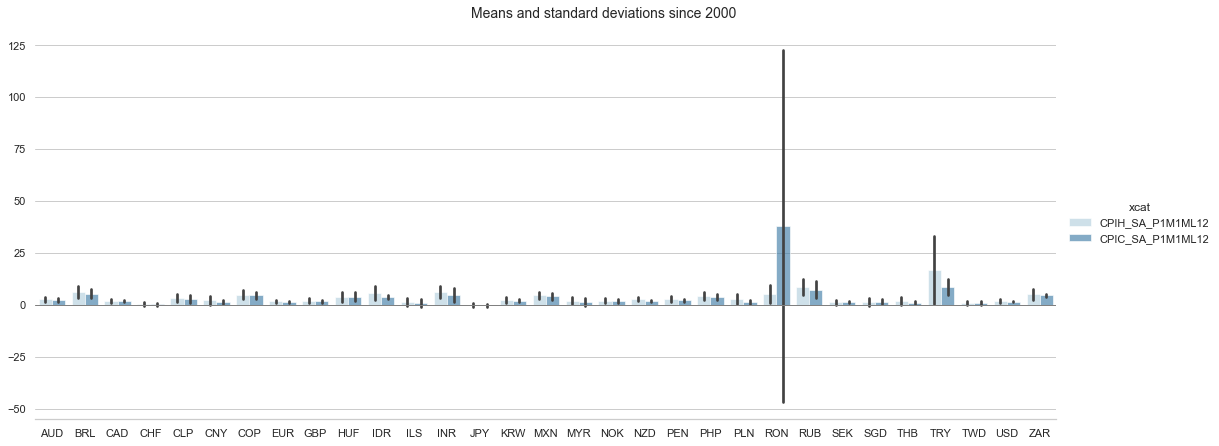

In [12]:
xcats_oya = ['CPIH_SA_P1M1ML12', 'CPIC_SA_P1M1ML12'] 
bars_sds(dfd, xcats=xcats_oya , cids=cids_exp)

Missing cross sections:  {'ITL', 'NLG', 'FRF', 'ESP', 'DEM'}


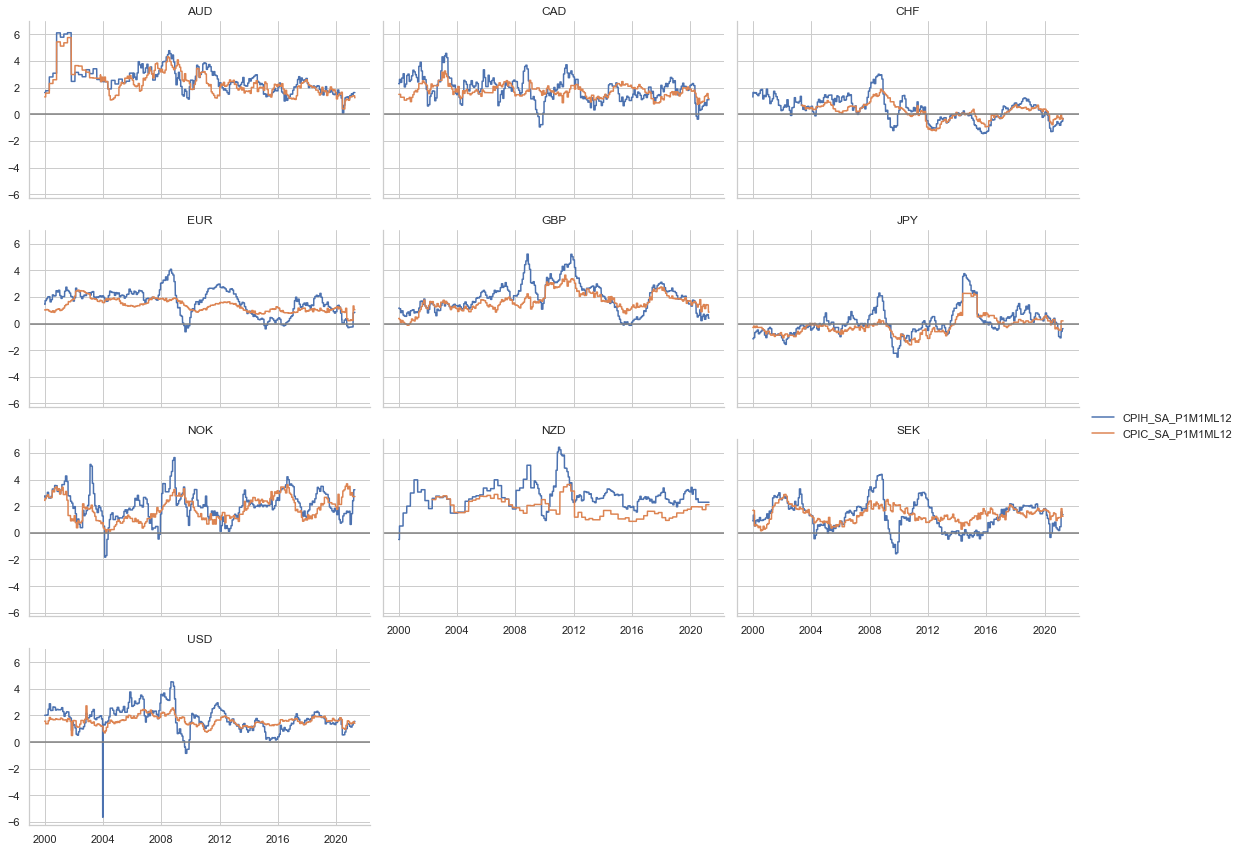

In [13]:
timeline_grid(dfd, xcats=xcats_oya, cids=cids_dm, hue='xcat', same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


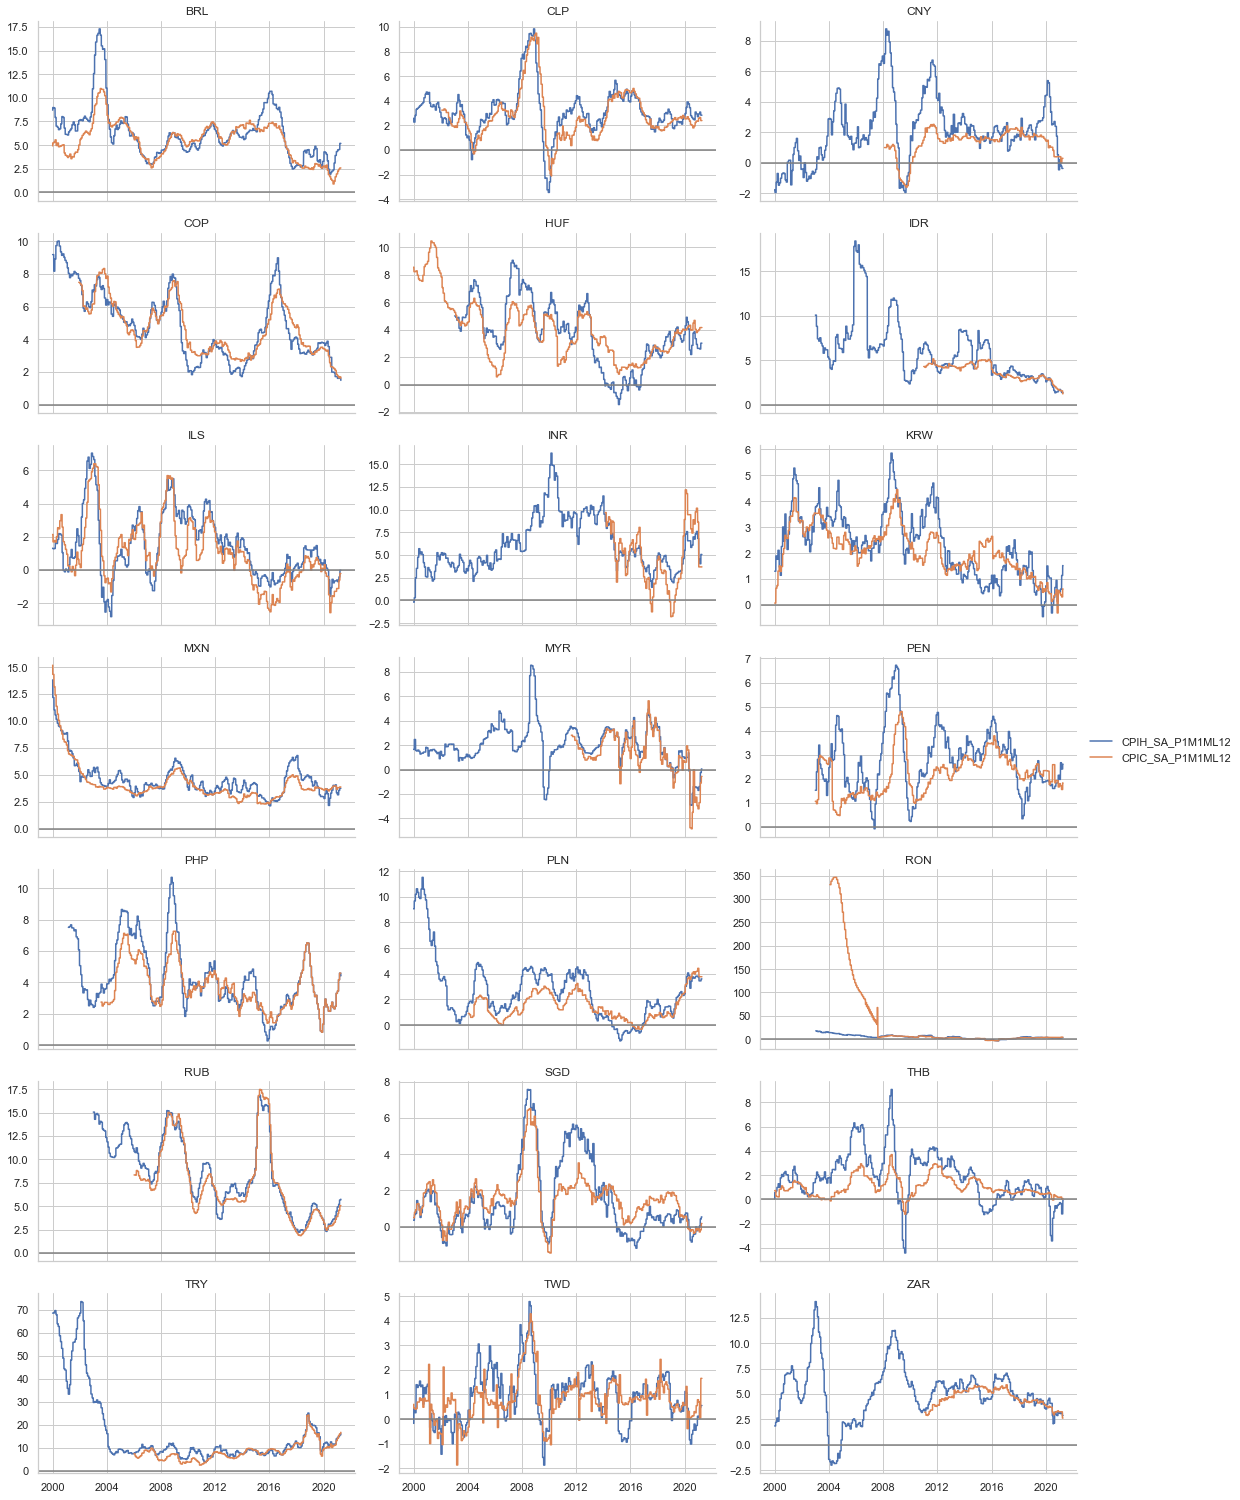

In [14]:
timeline_grid(dfd, xcats=xcats_oya, cids=cids_em, hue='xcat', same_y=False)

### Changes in annual inflation rates

Missing cross sections:  set()


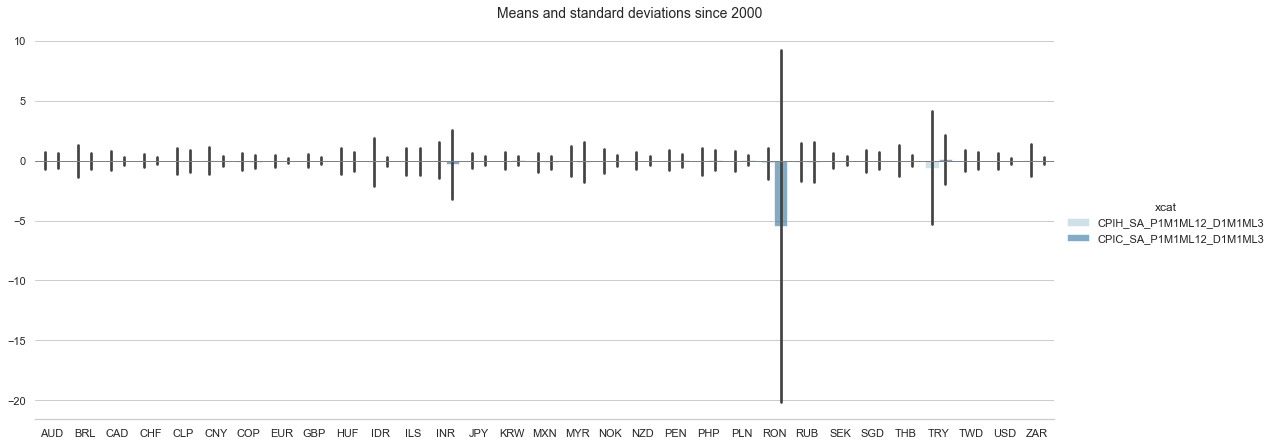

In [16]:
xcats_chy = ['CPIH_SA_P1M1ML12_D1M1ML3', 'CPIC_SA_P1M1ML12_D1M1ML3']
bars_sds(dfd, xcats=xcats_chy, cids=cids_exp)

Missing cross sections:  {'ITL', 'NLG', 'FRF', 'ESP', 'DEM'}


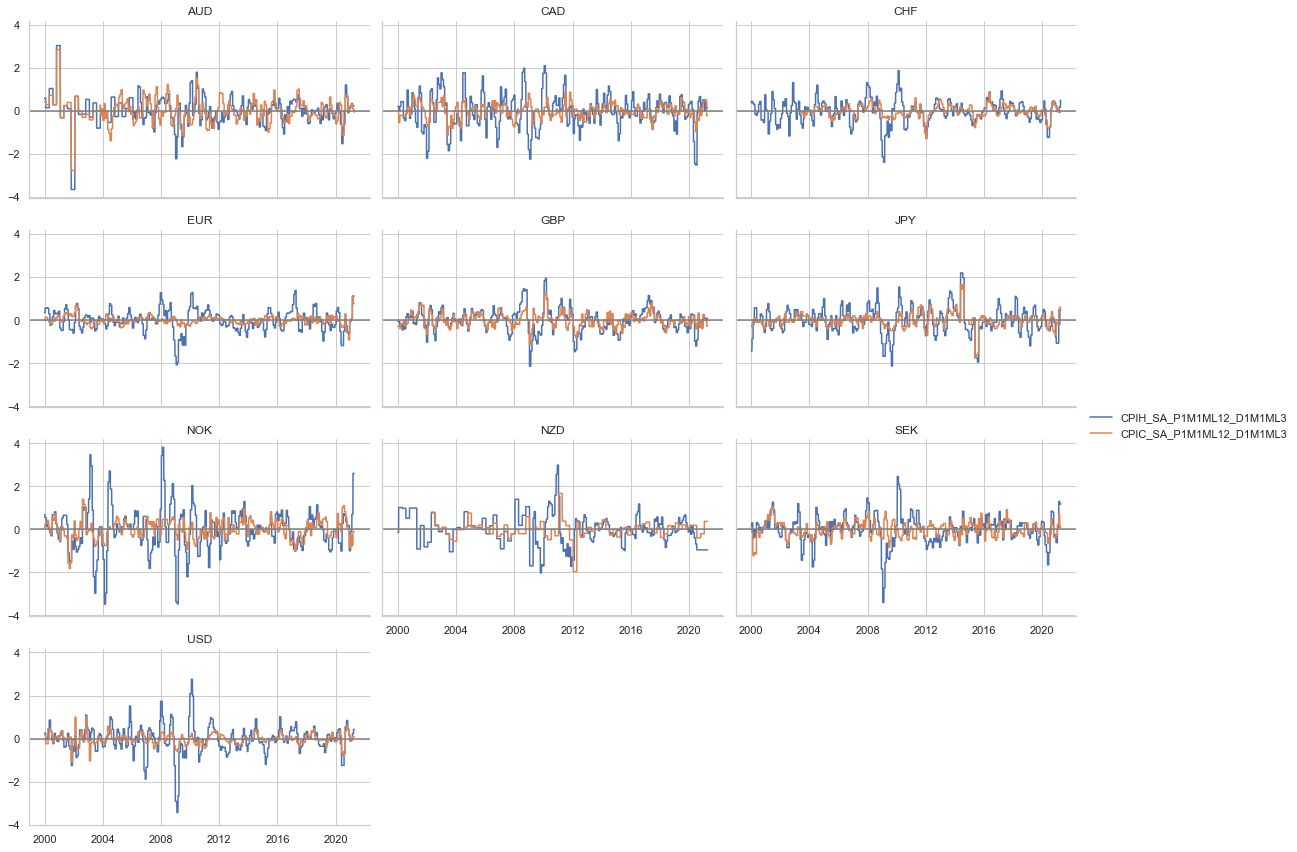

In [17]:
timeline_grid(dfd, xcats=xcats_chy, cids=cids_dm, hue='xcat', same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


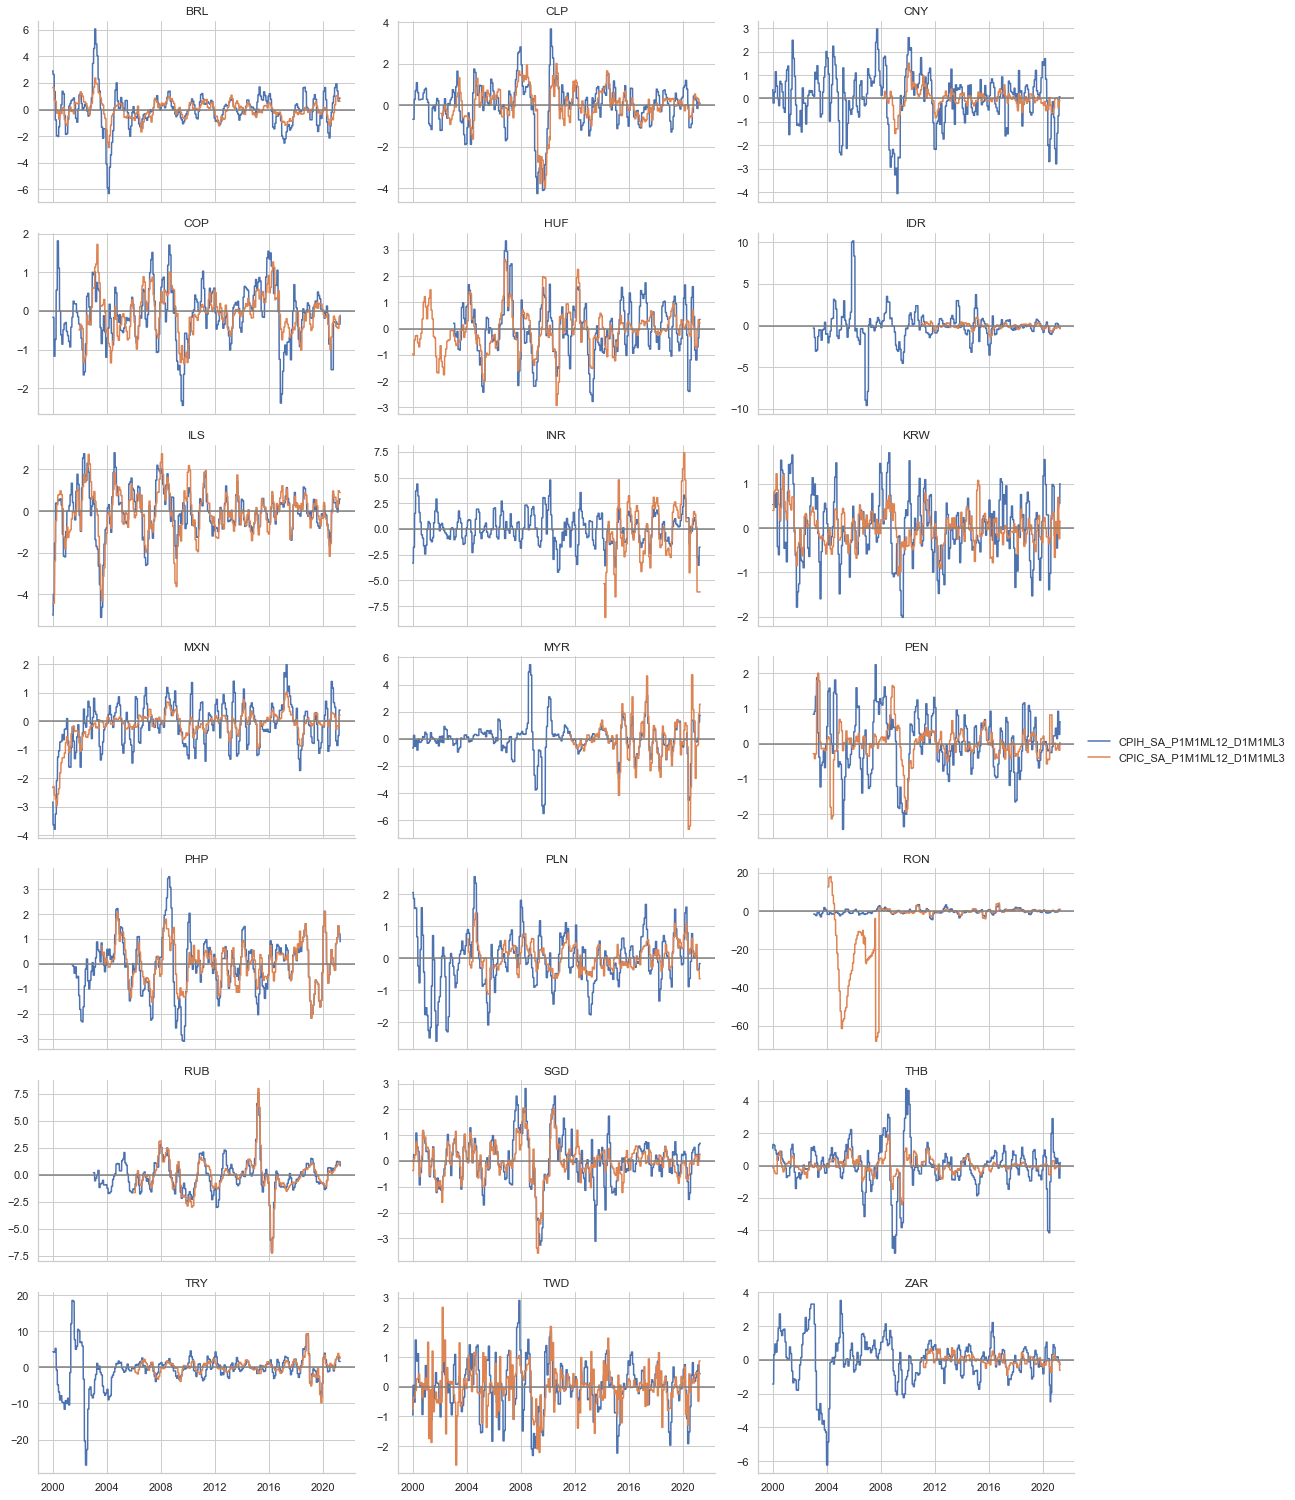

In [18]:
timeline_grid(dfd, xcats=xcats_chy, cids=cids_em, hue='xcat', same_y=False)

### Adjusted 6M/6M CPI trends

Missing cross sections:  set()


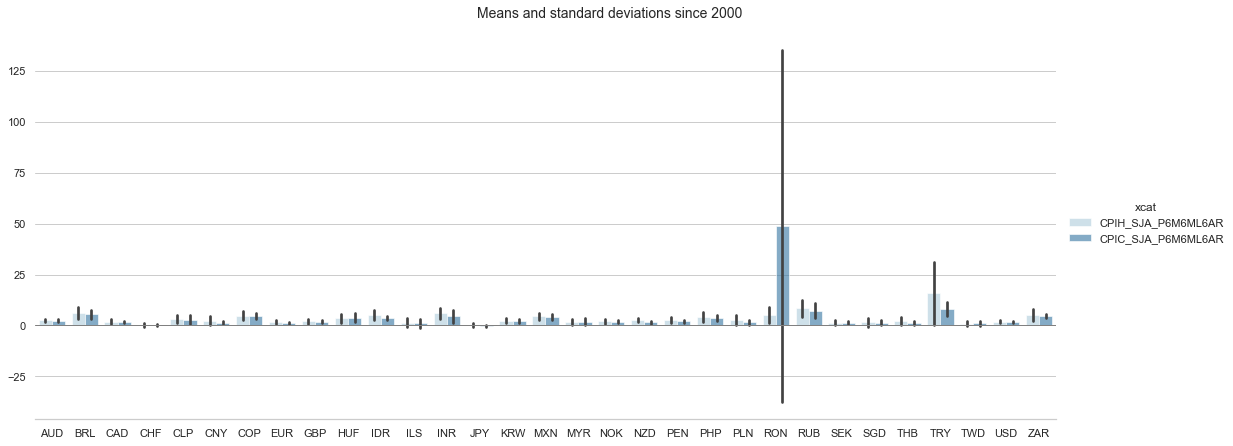

In [19]:
xcats_6mt = ['CPIH_SJA_P6M6ML6AR', 'CPIC_SJA_P6M6ML6AR']
bars_sds(dfd, xcats=xcats_6mt, cids=cids_exp)

Missing cross sections:  {'ITL', 'NLG', 'FRF', 'ESP', 'DEM'}


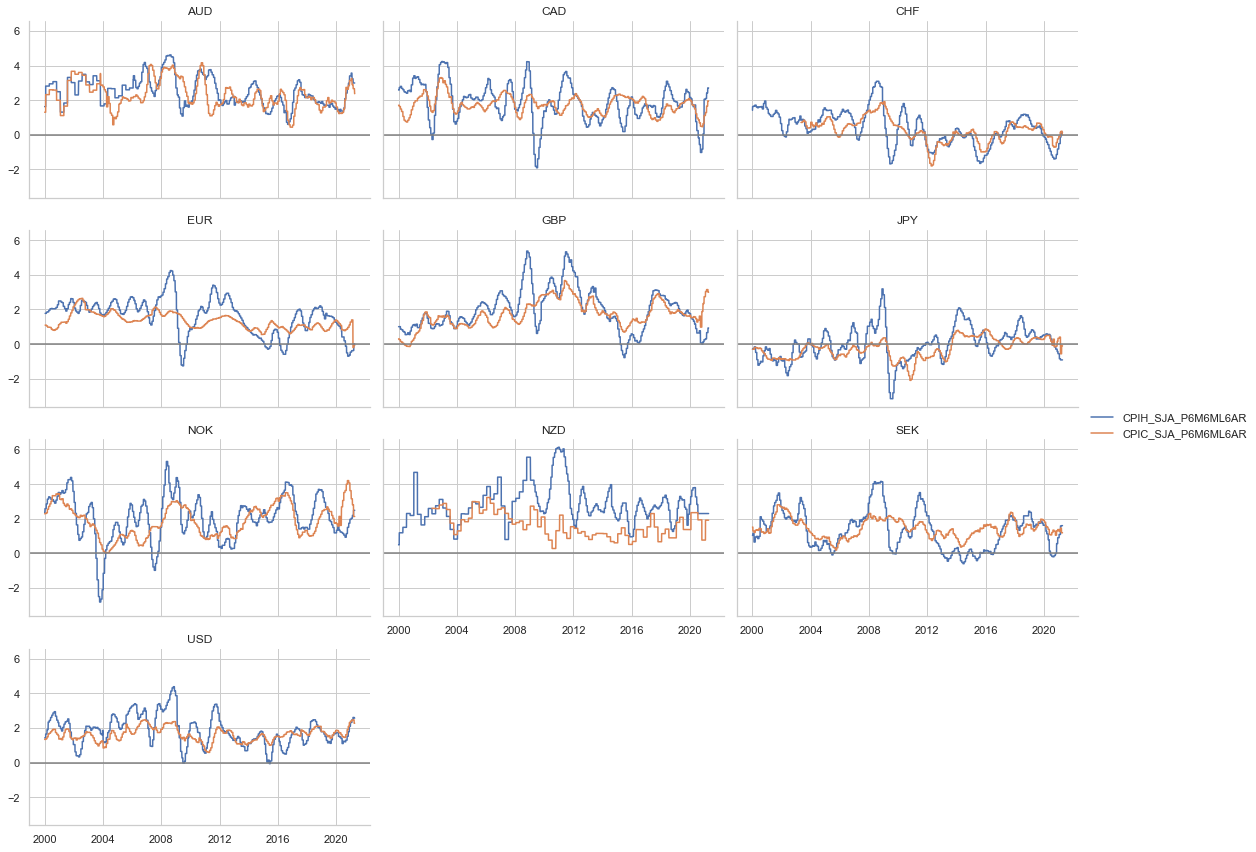

In [20]:
timeline_grid(dfd, xcats=xcats_6mt, cids=cids_dm, hue='xcat', same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


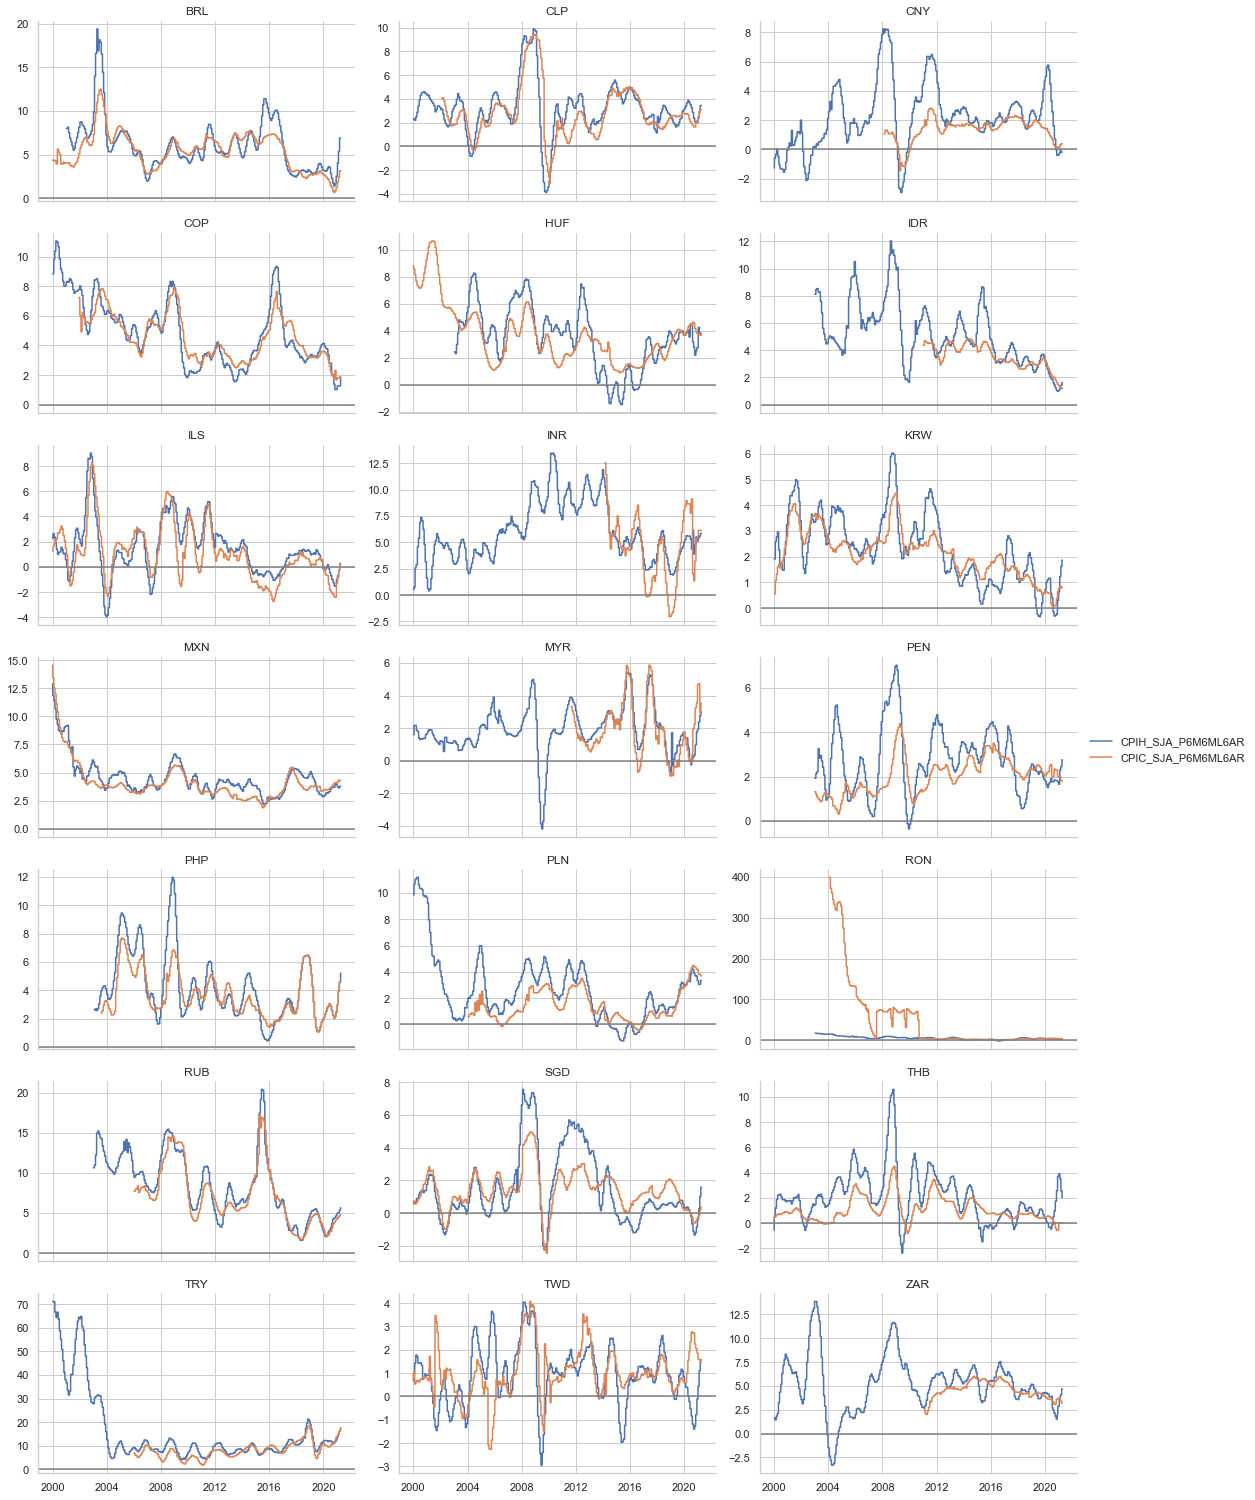

In [21]:
timeline_grid(dfd, xcats=xcats_6mt, cids=cids_em, hue='xcat', same_y=False)

### Adjusted 3M/3M CPI trends

Missing cross sections:  set()


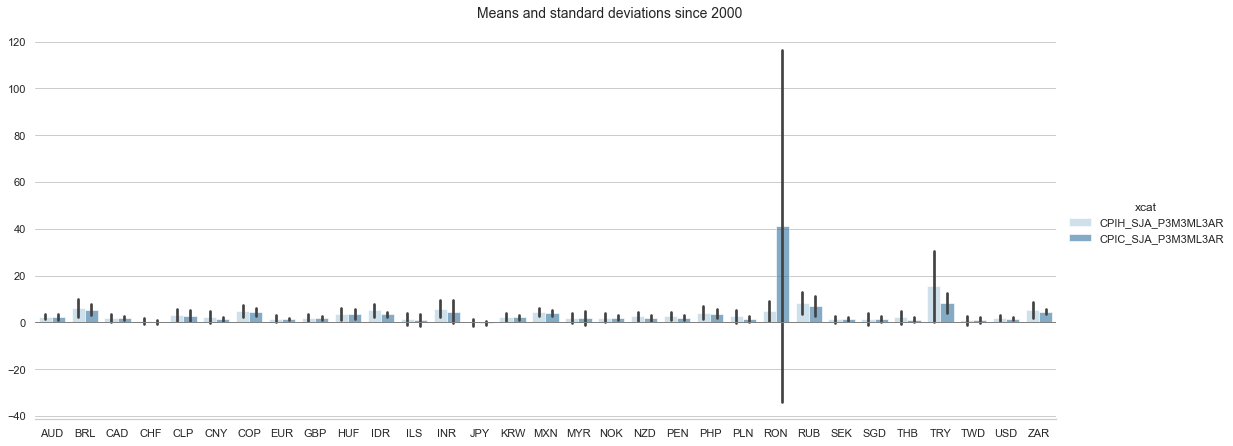

In [22]:
xcats_3mt = ['CPIH_SJA_P3M3ML3AR', 'CPIC_SJA_P3M3ML3AR']
bars_sds(dfd, xcats=xcats_3mt, cids=cids_exp)

Missing cross sections:  {'ITL', 'NLG', 'FRF', 'ESP', 'DEM'}


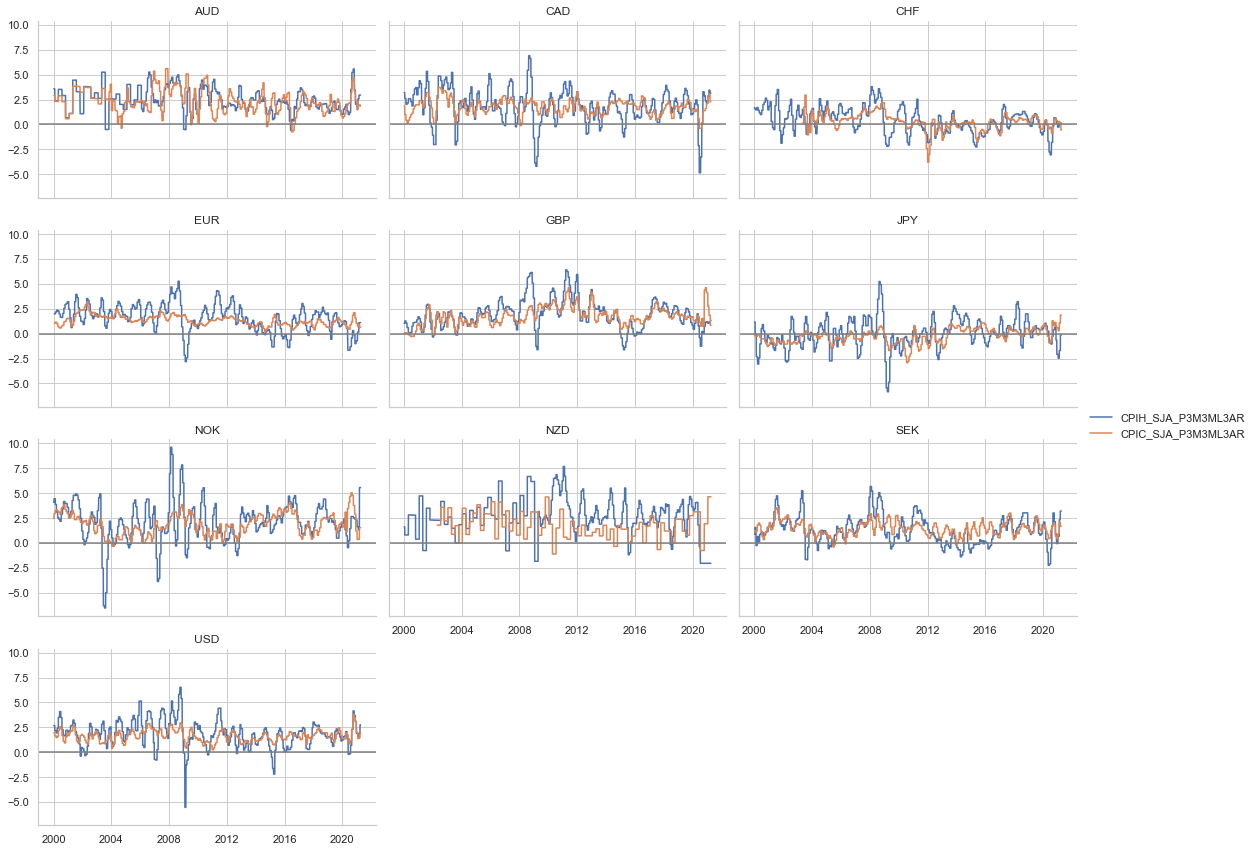

In [23]:
timeline_grid(dfd, xcats=xcats_3mt, cids=cids_dm, hue='xcat', same_y=True)

Missing cross sections:  {'ARS', 'HKD'}


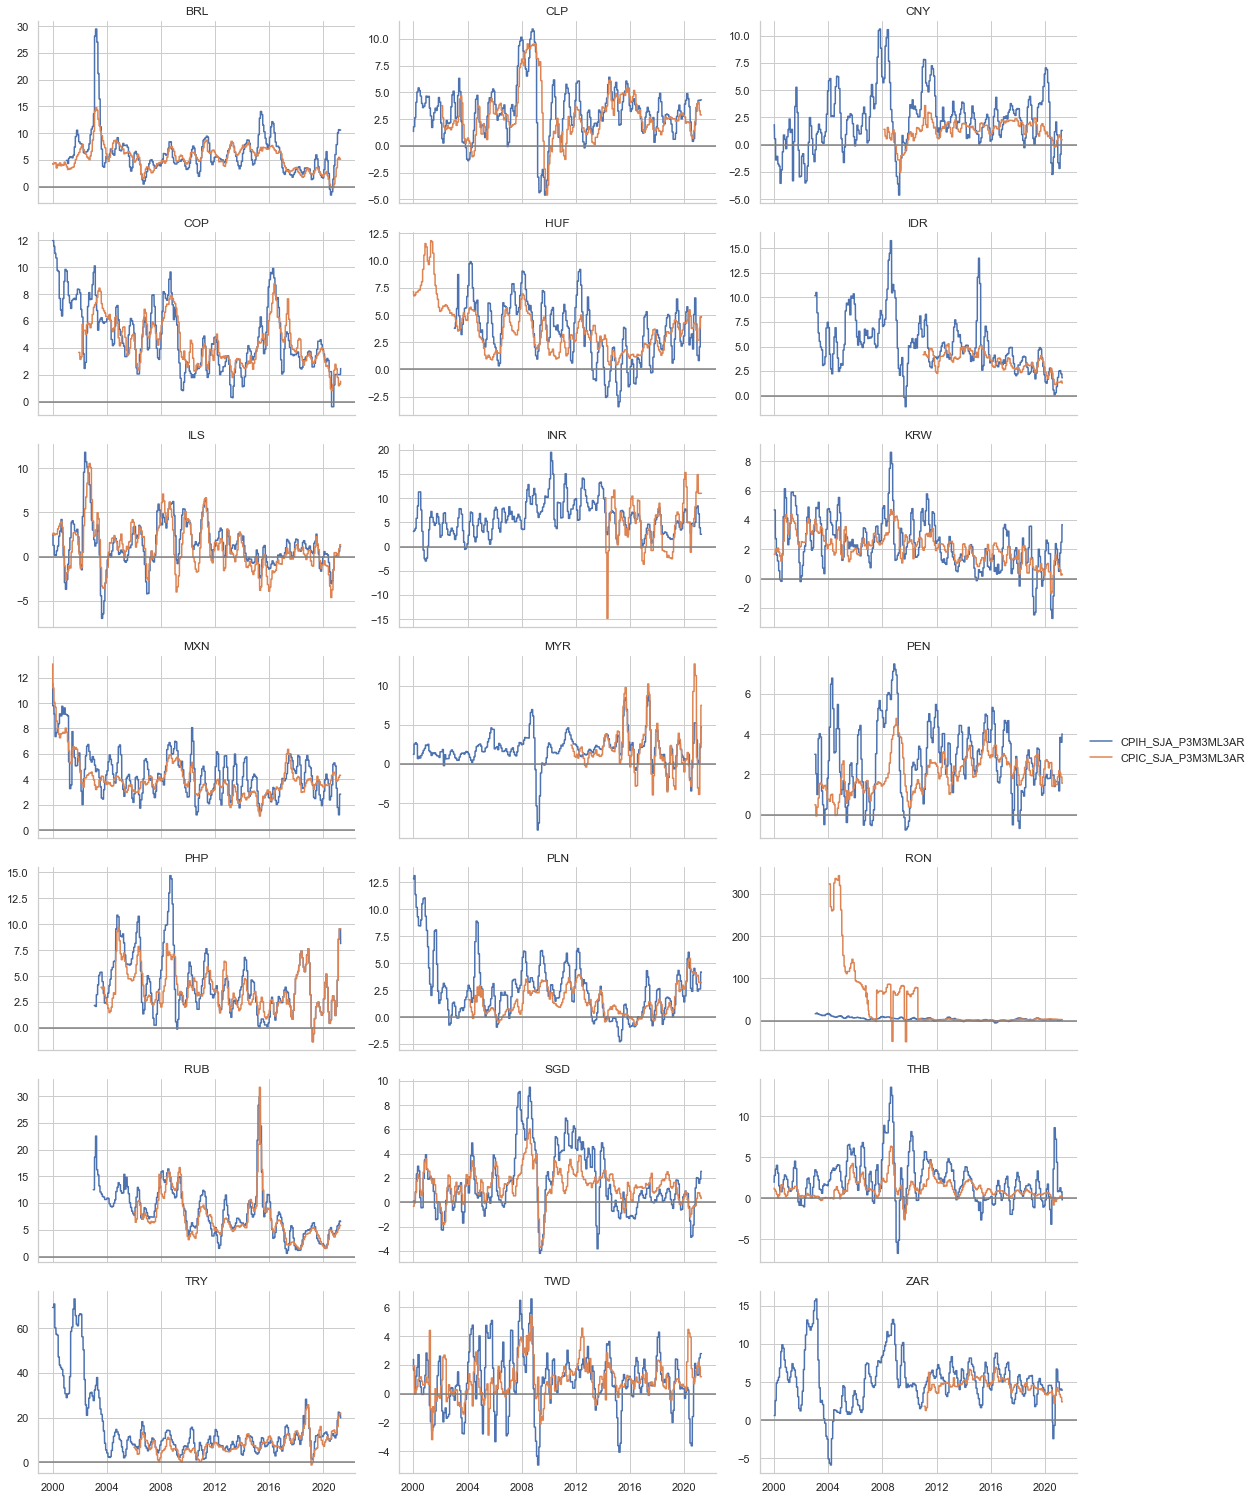

In [24]:
timeline_grid(dfd, xcats=xcats_3mt, cids=cids_em, hue='xcat', same_y=False)